In [22]:
import pandas as pd
import numpy as np
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
from rasterio.features import rasterize

# plotting
import matplotlib.pyplot as plt
import contextily as ctx
import shapely.geometry as geom

# Compile 2004 and 2022 datasets

In [23]:
# load data
s = pd.read_csv('../Data/GAA2/All_amphibians_tabular_data.CSV')

### Realm, Birth, Bio

In [24]:
# get realms and birth modes to numerical values
realm_keys = ['Afrotropical', 'Australasian/Oceanian', 'Indomalayan', 'Nearctic', 'Neotropical', 'Palearctic']
birth_keys = ['Egg Laying', 'Free Living Larval Stage', 'Live Birth ', 'Water Breeding']

# for birth_keys, replace unknown with nan, 'Yes with 1, 'No' with 0
for col in birth_keys:
    s[col] = s[col].replace('Unknown', np.nan)
    s[col] = s[col].replace('Yes', 1)
    s[col] = s[col].replace('No', 0)
    
# for realm keys, replace nan with 0
for col in realm_keys:
    s[col] = s[col].replace(np.nan, 0)

# add one column N_realm with number of realms
s['N_realm'] = s[realm_keys].sum(axis=1)

# ---

# check out how many entries are Unknown
for col in birth_keys:
    print(col, 'total', s[col].count(),
          'unknown:' , s[col].loc[s[col] == np.nan].count())

# check out how many N_realm 2 or grater and 3 or greater
print()
print('N_realm 2 or greater:', s['N_realm'].loc[s['N_realm'] >= 2].count())
print('N_realm 3 or greater:', s['N_realm'].loc[s['N_realm'] >= 3].count())

s.head()

Egg Laying total 7884 unknown: 0
Free Living Larval Stage total 7837 unknown: 0
Live Birth  total 7884 unknown: 0
Water Breeding total 7809 unknown: 0

N_realm 2 or greater: 263
N_realm 3 or greater: 2


,Order,Family,Species Name,1980 GAA2 Red List Category,2004 GAA2 Red List Category,1980-2004 Genuine Change?,1980-2004 Primary Driver,Grouped 1980-2004 Primary Driver,1980-2004 Genuine downlisting due to conservation,2022 GAA2 Red List Category,2022 Red List Criteria,2004-2022 Genuine Change?,2004-2022 Primary Driver,Grouped 2004-2022 Primary Driver,2004-2022 Genuine downlisting due to conservation,Afrotropical,Australasian/Oceanian,Indomalayan,Nearctic,Neotropical,Palearctic,Egg Laying,Free Living Larval Stage,Live Birth,Water Breeding,N_realm
0,ANURA,RANIDAE,Abavorana luctuosa,LC,LC,No,NaN,NaN,NaN,LC,NaN,No,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
1,ANURA,RANIDAE,Abavorana nazgul,CR,CR,No,NaN,NaN,NaN,CR,B1ab(iii),No,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
2,ANURA,HYPEROLIIDAE,Acanthixalus sonjae,VU,VU,No,NaN,NaN,NaN,VU,B2ab(iii),No,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
3,ANURA,HYPEROLIIDAE,Acanthixalus spinosus,LC,LC,No,NaN,NaN,NaN,LC,NaN,No,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4,ANURA,HYLIDAE,Acris blanchardi,LC,LC,No,NaN,NaN,NaN,LC,NaN,No,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0


Lucas et al., 2023 grouped the habitat varaibles, see [supplementary](https://www.biorxiv.org/content/10.1101/2023.02.08.526823v1.supplementary-material), table A8


In [25]:
# import database on amphibian biology
bio = pd.read_csv('../Data/AmphiBIO/AmphiBIO_v1.csv', encoding='latin1')

# pd.set_option('display.max_columns', None)

# look at the overlap between bio['Species'] and s['Species Name']
# get fraction of bio that is also present in s

# bio_comp = s.loc[s['Species Name'].isin(bio['Species'].values)]

# group microhabitat variable as in Lucas et al.
microhabitats_keys = ['Fos', 'Ter', 'Aqu', 'Arb']
microhabitats = bio.loc[:, microhabitats_keys].replace(np.nan, 0)
microhabitats

# add three new columns to microhabitats: Generalist, Semiaquatic, Other
# Semiaquatic are all species [Fos, Ter, Aqu, Arb] = [0, 1, 1, 0]
microhabitats['SemiAqua'] = (1 - microhabitats['Fos']) * microhabitats['Aqu'] * microhabitats['Ter'] * (1 - microhabitats['Arb'])

# Generalist are all species with at least two microhabitats
microhabitats['Generalist'] = (microhabitats[microhabitats_keys].sum(axis=1) > 1).astype(float)
## terrestrial only are also generalists
microhabitats['Generalist'] = microhabitats['Generalist'] + (microhabitats['Ter'] * (microhabitats[microhabitats_keys].sum(axis=1) == 1))
## all specials with Ter and exactly one other microhabitat are not generalists
microhabitats['Generalist'] = microhabitats['Generalist'] - (microhabitats['Ter'] * (microhabitats[microhabitats_keys].sum(axis=1) == 2))

# All species that are not generalists or semiaquatic are Other
microhabitats['Other'] = 1 - microhabitats['Generalist'] - microhabitats['SemiAqua']

bio.keys()

# Other biological traits (counts of non-missing values below)
# Body_size_mm                                         4432
# Offspring_size_min_mm                                1160
# Offspring_size_max_mm                                1160
# Wet_warm                                              649
# Wet_cold                                              130
# Dry_warm                                              161
# Dry_cold                                               38
# for now, skip these variables, since it is not clear how to deal with all the missing values
important_keys = ['Body_size_mm']
bio_vars = bio.loc[:, important_keys]#.replace(np.nan, 0)
bio_vars['Species'] = bio['Species']


# add species name to grouped microhabitats 
microhabitats['Species'] = bio['Species']
microhabitats = microhabitats.drop(columns=microhabitats_keys)

# incorporate microhabitats into s
print('number of species before merge:', s.shape[0])
s = s.merge(microhabitats, left_on='Species Name', right_on='Species', how='inner')
s = s.merge(bio_vars, left_on='Species Name', right_on='Species', how='inner')
print('number of species after merge:', s.shape[0])

number of species before merge: 8011
number of species after merge: 5706


In [26]:

# drop 2004 related columns
pred2022 = s.drop(columns=['1980 GAA2 Red List Category', '1980-2004 Genuine Change?',
                    '1980-2004 Primary Driver', 'Grouped 1980-2004 Primary Driver',
                    '1980-2004 Genuine downlisting due to conservation'])

# drop 2022 related columns
pred2004 = s.drop(columns=['2022 GAA2 Red List Category', '2004-2022 Genuine Change?',
                    ' 2004-2022 Primary Driver', 'Grouped 2004-2022 Primary Driver',
                    '2004-2022 Genuine downlisting due to conservation'])

### Binary category change

In [27]:
# remove data deficient species
pred2022 = pred2022.loc[~(pred2022['2004 GAA2 Red List Category'] == 'DD')]
pred2004 = pred2004.loc[~(pred2004['1980 GAA2 Red List Category'] == 'DD')]

# remove species already extinct in wild 'EW' or extinct 'EX' in 2004
pred2022 = pred2022.loc[~(pred2022['2004 GAA2 Red List Category'] == 'EW')]
pred2022 = pred2022.loc[~(pred2022['2004 GAA2 Red List Category'] == 'EX')]

pred2004 = pred2004.loc[~(pred2004['1980 GAA2 Red List Category'] == 'EW')]
pred2004 = pred2004.loc[~(pred2004['1980 GAA2 Red List Category'] == 'EX')]

# replace categories by numerical values: 'LC' = 1, 'NT' = 2, 'VU' = 3, 'EN' = 4, 'CR' & 'CR(PE)' = 6, 'EW' & 'EX' = 6
category_dict = {'LC': 1, 'NT': 2, 'VU': 3, 'EN': 4, 'CR': 5, 'CR(PE)': 6, 'CR(PEW)': 6, 'EW': 6, 'EX': 6}

pred2022['2004 RL num'] = pred2022['2004 GAA2 Red List Category'].replace(category_dict)
pred2022['2022 RL num'] = pred2022['2022 GAA2 Red List Category'].replace(category_dict)

pred2004['1980 RL num'] = pred2004['1980 GAA2 Red List Category'].replace(category_dict)
pred2004['2004 RL num'] = pred2004['2004 GAA2 Red List Category'].replace(category_dict)

pred2022.head()

,Order,Family,Species Name,2004 GAA2 Red List Category,2022 GAA2 Red List Category,2022 Red List Criteria,2004-2022 Genuine Change?,2004-2022 Primary Driver,Grouped 2004-2022 Primary Driver,2004-2022 Genuine downlisting due to conservation,Afrotropical,Australasian/Oceanian,Indomalayan,Nearctic,Neotropical,Palearctic,Egg Laying,Free Living Larval Stage,Live Birth,Water Breeding,N_realm,SemiAqua,Generalist,Other,Species_x,Body_size_mm,Species_y,2004 RL num,2022 RL num
0,ANURA,HYPEROLIIDAE,Acanthixalus sonjae,VU,VU,B2ab(iii),No,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,Acanthixalus sonjae,38.5,Acanthixalus sonjae,3,3
1,ANURA,HYPEROLIIDAE,Acanthixalus spinosus,LC,LC,NaN,No,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Acanthixalus spinosus,38.3,Acanthixalus spinosus,1,1
2,ANURA,HYLIDAE,Acris blanchardi,LC,LC,NaN,No,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,Acris blanchardi,38.0,Acris blanchardi,1,1
3,ANURA,HYLIDAE,Acris crepitans,LC,LC,NaN,No,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,Acris crepitans,38.0,Acris crepitans,1,1
4,ANURA,HYLIDAE,Acris gryllus,LC,LC,NaN,No,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,Acris gryllus,32.0,Acris gryllus,1,1


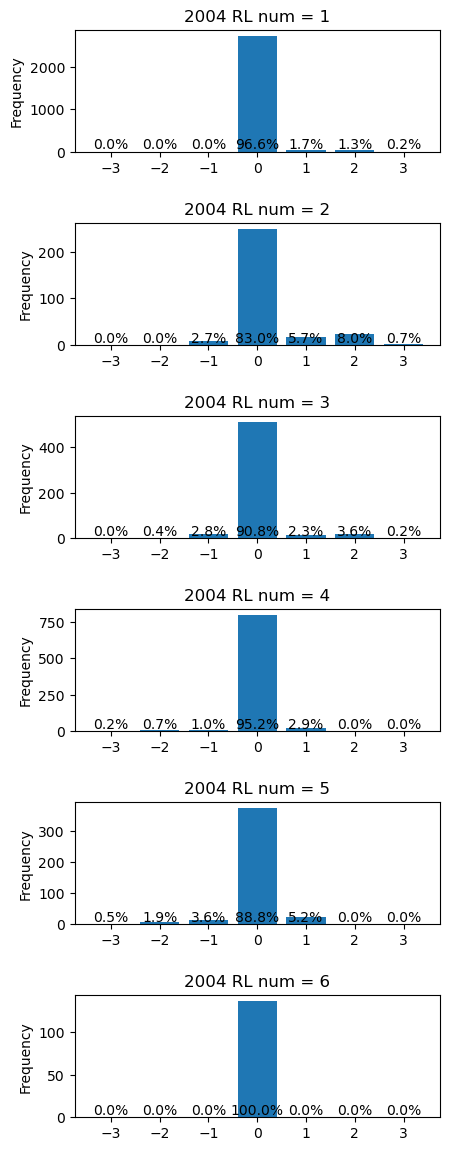

In [28]:
# plot histogram of red list transitions for each 2004 RL num

RLidx = pred2022[['2004 RL num', '2022 RL num']].copy()
RLidx['change'] = RLidx['2022 RL num'] - RLidx['2004 RL num']

fig, ax = plt.subplots(6,1, figsize=(5,12))
fig.tight_layout(pad=3)
for i in range(1,7):
    RLidx.loc[RLidx['2004 RL num'] == i].change.plot.hist(ax=ax[i-1], bins=[-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5], rwidth=0.8)
    ax[i-1].set_title('2004 RL num = {}'.format(i))
    # write percentages into bars
    for j in range(-3,4):
        ax[i-1].text(j, 0, str(round(RLidx.loc[RLidx['2004 RL num'] == i].change.loc[RLidx['change'] == j].count() / RLidx.loc[RLidx['2004 RL num'] == i].change.count() * 100, 1)) + '%', ha='center', va='bottom')



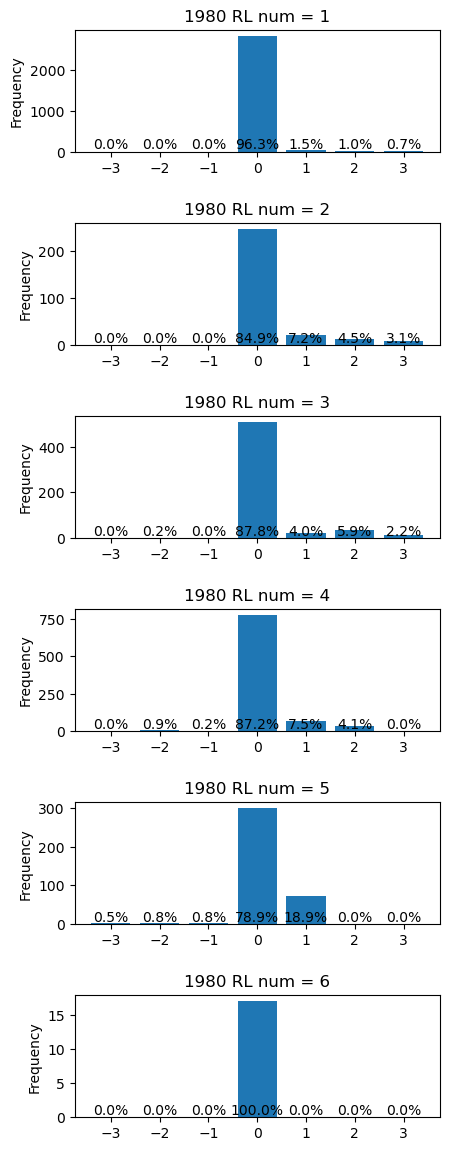

In [29]:
# plot histogram of red list transitions for each 2004 RL num

RLidx = pred2004[['2004 RL num', '1980 RL num']].copy()
RLidx['change'] = RLidx['2004 RL num'] - RLidx['1980 RL num']

fig, ax = plt.subplots(6,1, figsize=(5,12))
fig.tight_layout(pad=3)
for i in range(1,7):
    RLidx.loc[RLidx['1980 RL num'] == i].change.plot.hist(ax=ax[i-1], bins=[-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5], rwidth=0.8)
    ax[i-1].set_title('1980 RL num = {}'.format(i))
    # write percentages into bars
    for j in range(-3,4):
        ax[i-1].text(j, 0, str(round(RLidx.loc[RLidx['1980 RL num'] == i].change.loc[RLidx['change'] == j].count() / RLidx.loc[RLidx['1980 RL num'] == i].change.count() * 100, 1)) + '%', ha='center', va='bottom')



**Category transition following DiMarco et al., 2015**

(i) randomly re-assigne the observed transitions across all species within each original Red List category\
(ii) compare the observed transitions with the randomly assigned transitions\
(iii) repeated the previous steps 10 000 times\
(iv) transition value higher than random in $\leq$ 5%: ‘lower risk’, transition value higher than random $>$ 5%: ‘higher risk’ group

In [30]:
# get differences for all iterations.
# positive means transition value higher than random (worse than random)
iterations = 10000
difference = np.full([iterations, len(pred2022)], np.nan)

for i in range(iterations):
    for cat in range(1,5+1):
        # get indices of all species with 2004 RL category cat
        idx = np.where(pred2022['2004 RL num'] == cat)[0].tolist()
        # reshuffle these indices
        idx_shuffled = np.random.permutation(idx)
        # calc difference of randomly assigned 2004-2022 change to actual change
        actual_change = pred2022['2022 RL num'].values[idx] - pred2022['2004 RL num'].values[idx]  
        random_change = pred2022['2022 RL num'].values[idx_shuffled] - pred2022['2004 RL num'].values[idx]
        difference[i][idx] = actual_change - random_change
        
# get fraction of each row of values greater than 0
fraction = np.sum(difference > 0, axis=0) / iterations

# assign 1 to fractions greater that 5% and 0 to others
higher_risk = (fraction > 0.05).astype(int)

# assign column to pred2022
pred2022['higher risk'] = higher_risk

KeyboardInterrupt: 

In [48]:
# for pred2004, classify all positive changes as higher risk
# and classify changes of 0 from class 5 in 1980 as higher risk

actual_change = pred2004['2004 RL num'].values - pred2004['1980 RL num'].values 

higher_risk = (actual_change > 0).astype(int)
higher_risk = higher_risk + (actual_change == 0).astype(int) * (pred2004['1980 RL num'] == 5).astype(int)

pred2004['higher risk'] = higher_risk

In [49]:
# print how many species are higher risk
print('total:', len(pred2022))
print('higher risk:', pred2022['higher risk'].sum())
print('genuine change:', pred2022['Species Name'].loc[pred2022['2004-2022 Genuine Change?'].str.contains('uplisted')].count())
print('oberlap:', pred2022['Species Name'].loc[pred2022['2004-2022 Genuine Change?'].str.contains('uplisted') & pred2022['higher risk'] == 1].count())
print()
print('Categories that yield higher risk, if there is no genuine change:')
print(pred2022['2004 GAA2 Red List Category'].loc[(~ pred2022['2004-2022 Genuine Change?'].str.contains('uplisted')) & pred2022['higher risk'] == 1].unique()[0])

total: 5081


KeyError: 'higher risk'

In [31]:
# how many species with '2004 RL num' == 5 have '2022 RL num' < 5?
print('1980 - 2004:')
print('downlisted critically endangered:', 
      len(pred2004.loc[(pred2004['1980 RL num'] == 5) & (pred2004['2004 RL num'] < 5)]))

# how many stay the same?
print('consistently critically endangered:',
      len(pred2004.loc[(pred2004['1980 RL num'] == 5) & (pred2004['2004 RL num'] == 5)]))
print()

print('2004 - 2022:')
print('downlisted critically endangered:', 
      len(pred2022.loc[(pred2022['2004 RL num'] == 5) & (pred2022['2022 RL num'] < 5)]))

# how many stay the same?
print('consistently critically endangered:',
      len(pred2022.loc[(pred2022['2004 RL num'] == 5) & (pred2022['2022 RL num'] == 5)]))

1980 - 2004:
downlisted critically endangered: 8
consistently critically endangered: 300

2004 - 2022:
downlisted critically endangered: 25
consistently critically endangered: 374


### Landuse and human footprint
One of the preblems here is that, for each species we have calculated the landuse for potentially multiple poligons of their fractured range. Be $x_i$ the value of a land use variable in the grid cell $i$ with area $a_i$. Then, we have calculated the average land use of a poligon as

$$ X = \frac{\sum_{i} x_i a_i}{\sum_i a_i} $$

where we sumed over indices $i$ in within one polygon. We have calculated this area wheighted average $X^{(k)}$ and for different polygons. We have also calculated their areas $A^{(k)}$. Thus, the wheighted average, taking all polygons together, is

$$ \frac{\sum_i x^{(1)}_i a^{(1)}_i + \sum_j x^{(2)}_j a^{(2)}_j + ...}{\sum_i a^{(1)}_i + \sum_j a^{(2)}_j + ...} = \frac{X^{(1)} A^{(1)} + X^{(2)} A^{(2)} + ...}{A^{(1)} + A^{(2)} + ...} $$

The same applies to climate variables and climate niche fractions. In the latter, $x_i \in \{0,1\}$ , representing if a particular cell has crossed it's niche or not.\

Let's consider land use change 

$$ D = \frac{\sum_{i} (x_i - y_i) a_i}{\sum_i a_i} = \frac{\sum_{i} x_i a_i}{\sum_i a_i} - \frac{\sum_{i} y_i a_i}{\sum_i a_i} = X - Y $$

Now, to calculate the changes in land use, we can either do it based on the land use values of the individual polygons ($X^{(k)}, Y^{(k)}$) or based on their land use change values $D^{(k)}$

\begin{align}
    &\frac{X^{(1)} A^{(1)} + X^{(2)} A^{(2)} + ...}{A^{(1)} + A^{(2)} + ...} - \frac{Y^{(1)} A^{(1)} + Y^{(2)} A^{(2)} + ...}{A^{(1)} + A^{(2)} + ...}\\
    \\
    &= \frac{(X^{(1)} - Y^{(1)}) A^{(1)}}{A^{(1)} + A^{(2)} + ...} + \frac{(X^{(2)} - Y^{(2)}) A^{(2)}}{A^{(1)} + A^{(2)} + ...} + ...\\
    \\
    &= \frac{D^{(1)}A^{(1)} + D^{(2)}A^{(2)} + ...}{A^{(1)} + A^{(2)} + ...}
\end{align}

So it comes down to again calculating the difference individually and then taking the area wheighted mean. The same applies, of course, to climate change values for polygons.

Finally, the population density of grid cells $p_i$ is aggregated as

$$ P = \log\left(\frac{\sum_i p_i a_i}{\sum_i a_i} + 1\right) $$

So taking different polygons together yields

\begin{align}
    & \log\left(\frac{\sum_i p^{(1)}_i a^{(1)}_i + \sum_j p^{(2)}_j a^{(2)}_j + ...}{\sum_i a^{(1)}_i + \sum_j a^{(2)}_j + ...} + 1\right)\\
    \\
    &= \log\left[\frac{(\exp(P^{(1)}) - 1)A^{(1)} + (\exp(P^{(2)}) - 1)A^{(2)} + ...}{A^{(1)} + A^{(2)} + ...} + 1\right]
\end{align}

Which is again just an area wheighted average, inside a forth and back $\log(x+1)$ transformation.

In [32]:
# add landuse and landuese change variables
hf = pd.read_csv('gaa2_hf_tt_area_2021_2004_1980.csv')

# add landuse and landuese change variables
keys = ['urbanareas', 'cropland', 'rangeland', 'managed_pasture']

# get landuse variables
landuse_2021 = hf.loc[:, hf.columns.str.contains('|'.join(keys)) & hf.columns.str.contains('2021')].copy()
landuse_2004 = hf.loc[:, hf.columns.str.contains('|'.join(keys)) & hf.columns.str.contains('2004')].copy()
landuse_1980 = hf.loc[:, hf.columns.str.contains('|'.join(keys)) & hf.columns.str.contains('1980')].copy()

# get population density and travel time 
# !! Travel time for 2000 is wrong (same as 2015) !! Pop density for 1980 is wrong (same as 2004)!!
pop_density = hf.loc[:, hf.columns.str.contains('population_density')].copy()
travel_time = hf.loc[:, hf.columns.str.contains('travel_time')].copy()

# for pop density, get value and change for 2021 aswell as 2004
pop_density.loc[:, 'population_density_change_2021'] = (pop_density['population_density_2021'] - pop_density['population_density_2004']).values
pop_density.loc[:, 'population_density_change_2004'] = (pop_density['population_density_2004'] - pop_density['population_density_1980']).values
pop_2021 = pop_density.loc[:, ['population_density_2021', 'population_density_change_2021']]
pop_2004 = pop_density.loc[:, ['population_density_2004', 'population_density_change_2004']]

# get travel time for 2000 and 2015
travel_2015 = travel_time.loc[:, ['travel_time_2015']]
travel_2000 = travel_time.loc[:, ['travel_time_2000']]

In [33]:
### 2004 - 2022 ###

# take difference 2021 - 2004 and add columns to landuse_2021
## change the '2004' in columns to '2021' for consistent substraction
landuse_2004_copy = landuse_2004.copy()
landuse_2004_copy.columns = [col.replace('2004', '2021') for col in landuse_2004.columns]
landuse_change = landuse_2021 - landuse_2004_copy
landuse_change.columns = [col + '_change' for col in landuse_change.columns]

# get landuse df including change and area 
landuse = pd.concat([landuse_2021, landuse_change], axis=1)
area = hf[['area_2021']]

# multiply all landuse columns with area column
lansude_area = landuse.mul(area['area_2021'], axis=0)
travel_time_area = travel_2015.mul(area['area_2021'], axis=0) # varied for 2004/2022
pop_density_area = pop_2021.mul(area['area_2021'], axis=0) # varied for 2004/2022

# individually sum cvar * area and area for each species, then take the ratio
landuse_area_grouped = lansude_area.groupby(hf['sci_name']).sum()
travel_time_area_grouped = travel_time_area.groupby(hf['sci_name']).sum()
pop_density_area_grouped = pop_density_area.groupby(hf['sci_name']).sum()

area_grouped = area.groupby(hf['sci_name']).sum()

# filter out all 0 entries
print('filtering out {} species with nan entries'
      .format((area_grouped['area_2021'].values == 0).sum()))

landuse_area_grouped = landuse_area_grouped.loc[~(landuse_area_grouped == 0).all(axis=1)]
travel_time_area_grouped = travel_time_area_grouped.loc[~(travel_time_area_grouped == 0).all(axis=1)]
pop_density_area_grouped = pop_density_area_grouped.loc[~(pop_density_area_grouped == 0).all(axis=1)]
area_grouped = area_grouped.loc[~(area_grouped == 0).all(axis=1)]

# take ratio
landuse_area_mean = landuse_area_grouped.div(area_grouped['area_2021'], axis=0)
travel_time_area_mean = travel_time_area_grouped.div(area_grouped['area_2021'], axis=0)
pop_density_area_mean = pop_density_area_grouped.div(area_grouped['area_2021'], axis=0)
landuse_area_mean['area_2021'] = area_grouped['area_2021']

# take log(x+1) for pop and travel time values (problem: negative values in pop change)
# pop_density_area_mean = np.log1p(pop_density_area_mean)

# merge with pred2022
# (only keep species that are present in both datasets)
pred2022_hf_2 = pred2022.merge(landuse_area_mean, left_on='Species Name', right_on=landuse_area_mean.index, how='inner')
pred2022_hf_1 = pred2022_hf_2.merge(travel_time_area_mean, left_on='Species Name', right_on=landuse_area_mean.index, how='inner')
pred2022_hf = pred2022_hf_1.merge(pop_density_area_mean, left_on='Species Name', right_on=landuse_area_mean.index, how='inner')

# see how many species overlap
print('len landuse_area_mean', len(landuse_area_mean))
print('len pred2022', len(pred2022))
print('len merged', len(pred2022_hf))

pd.set_option('display.max_columns', None)

filtering out 100 species with nan entries
len landuse_area_mean 7852
len pred2022 5081
len merged 4999


In [34]:
### 1980 - 2004 ###

# take difference 2004 - 1980 and add columns to landuse_2004
## change the '2004' in columns to '2021' for consistent substraction
landuse_1980.columns = [col.replace('1980', '2004') for col in landuse_2004.columns]
landuse_change = landuse_2004 - landuse_1980
landuse_change.columns = [col + '_change' for col in landuse_change.columns]

# get landuse df including change and area 
landuse = pd.concat([landuse_2004, landuse_change], axis=1)
area = hf[['area_2004']]

# multiply all landuse columns with area column
lansude_area = landuse.mul(area['area_2004'], axis=0)

# individually sum cvar * area and area for each species, then take the ratio
landuse_area_grouped = lansude_area.groupby(hf['sci_name']).sum()
area_grouped = area.groupby(hf['sci_name']).sum()

# filter out all 0 entries
print('filtering out {} species with nan entries'
      .format((area_grouped['area_2004'].values == 0).sum()))

cvars_area_grouped = landuse_area_grouped.loc[~(landuse_area_grouped == 0).all(axis=1)]
area_grouped = area_grouped.loc[~(area_grouped == 0).all(axis=1)]

# take ratio
landuse_area_mean = cvars_area_grouped.div(area_grouped['area_2004'], axis=0)
landuse_area_mean['area_2004'] = area_grouped['area_2004']

landuse_area_mean.head()

# only keep species that are present in both!!! datasets
pred2004_hf = pred2004.merge(landuse_area_mean, left_on='Species Name', right_on=landuse_area_mean.index, how='inner')

# see how many species overlap
print('len landuse_area_mean', len(landuse_area_mean))
print('len pred2004', len(pred2004))
print('len merged', len(pred2004_hf))

pd.set_option('display.max_columns', None)

pred2004_hf.head()

filtering out 100 species with nan entries
len landuse_area_mean 7852
len pred2004 5091
len merged 5009


,Order,Family,Species Name,1980 GAA2 Red List Category,2004 GAA2 Red List Category,1980-2004 Genuine Change?,1980-2004 Primary Driver,Grouped 1980-2004 Primary Driver,1980-2004 Genuine downlisting due to conservation,2022 Red List Criteria,Afrotropical,Australasian/Oceanian,Indomalayan,Nearctic,Neotropical,Palearctic,Egg Laying,Free Living Larval Stage,Live Birth,Water Breeding,N_realm,SemiAqua,Generalist,Other,Species_x,Body_size_mm,Species_y,1980 RL num,2004 RL num,urbanareas_2004,cropland_2004,rangeland_2004,managed_pasture_2004,urbanareas_2004_change,cropland_2004_change,rangeland_2004_change,managed_pasture_2004_change,area_2004
0,ANURA,HYPEROLIIDAE,Acanthixalus sonjae,VU,VU,No,NaN,NaN,NaN,B2ab(iii),1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,Acanthixalus sonjae,38.5,Acanthixalus sonjae,3,3,0.006019,0.243310,0.018324,0.202872,0.003589,0.107213,-0.016439,0.016818,3.074327e+04
1,ANURA,HYPEROLIIDAE,Acanthixalus spinosus,LC,LC,No,NaN,NaN,NaN,NaN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,Acanthixalus spinosus,38.3,Acanthixalus spinosus,1,1,0.001336,0.038819,0.078618,0.055666,0.000768,0.000609,-0.008519,0.010502,1.469794e+06
2,ANURA,HYLIDAE,Acris blanchardi,LC,LC,No,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,Acris blanchardi,38.0,Acris blanchardi,1,1,0.014857,0.344239,0.229247,0.110642,0.004183,-0.052009,0.009233,0.000429,2.688473e+06
3,ANURA,HYLIDAE,Acris crepitans,LC,LC,No,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,Acris crepitans,38.0,Acris crepitans,1,1,0.026721,0.192813,0.015673,0.118513,0.008114,-0.026462,0.000621,0.001867,1.248771e+06
4,ANURA,HYLIDAE,Acris gryllus,LC,LC,No,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,Acris gryllus,32.0,Acris gryllus,1,1,0.020448,0.166980,0.016062,0.063751,0.008381,-0.011917,-0.000123,0.001532,8.853077e+05


### Climate and climate change
- 5 climate variables (2002 - 2022) period
- 5 climate change variables (1984 - 2004) to (2002 - 2022)
- 5 climate niche fraction variables (s.o.)
- 5 climate niche fraction change variables (s.o.)

In [35]:
# Load cliamter data
c22 = pd.read_csv('gaa2_climate_2022.csv')
c04 = pd.read_csv('gaa2_climate_2004.csv')

# # get nichefrac columns for 2004 and 2021
# nfrac22 = c22.loc[:, c22.columns.str.contains('nichefrac')]
# nfrac04 = c04.loc[:, c04.columns.str.contains('nichefrac')]

# take difference 2021 - 2004 in nichefrac columns and add columns to c22
## change the '2004' in columns to '2021' for consistent substraction
# nfrac04.columns = [col.replace('2004', '2022') for col in nfrac04.columns]
# nfrac_change = nfrac22 - nfrac04
# change title of coumns e.g. 'AP_nichefrac_2022' --> 'AP_change_nichefrac_2022'
# nfrac_change.columns = ['_'.join([col.split('_')[0], 'change'] + col.split('_')[1:]) for col in nfrac_change.columns]

# get climate variables and area for species
# cvars_missing_nfrac_change = c22.loc[:, c22.columns.str.contains('2022')]
# cvars = pd.concat([cvars_missing_nfrac_change, nfrac_change], axis=1)

In [36]:
### 2022 ###

cvars = c22.loc[:, c22.columns.str.contains('2022')]
area = hf[['area_2021']]

# multiply all cvars columns with area column
cvars_area = cvars.mul(area['area_2021'], axis=0)

# individually sum cvar * area and area for each species, then take the ratio
cvars_area_grouped = cvars_area.groupby(c22['sci_name']).sum()
area_grouped = area.groupby(c22['sci_name']).sum()

# filter out all 0 entries
print('removing {} species with nan entries'
      .format((area_grouped['area_2021'].values == 0).sum()))

cvars_area_grouped = cvars_area_grouped.loc[~(cvars_area_grouped == 0).all(axis=1)]
area_grouped = area_grouped.loc[~(area_grouped == 0).all(axis=1)]

# take ratio
cvars_area_mean = cvars_area_grouped.div(area_grouped['area_2021'], axis=0)

# integrate these climate variables into pred2022
# only keep species that are present in both!!! datasets
pred2022_hf_c = pred2022_hf.merge(cvars_area_mean, left_on='Species Name', right_on=cvars_area_mean.index, how='inner')

# see how many species are nan in MAT_column_2022
print('len cvars_area_mean', len(cvars_area_mean))
print('len pred2022 HF', len(pred2022_hf))
print('len merged', len(pred2022_hf_c))

removing 100 species with nan entries
len cvars_area_mean 7852
len pred2022 HF 4999
len merged 4999


In [37]:
### 2004 ###

cvars = c04.loc[:, c04.columns.str.contains('2004')]
area = hf[['area_2004']]

# multiply all cvars columns with area column
cvars_area = cvars.mul(area['area_2004'], axis=0)

# individually sum cvar * area and area for each species, then take the ratio
cvars_area_grouped = cvars_area.groupby(c22['sci_name']).sum()
area_grouped = area.groupby(c22['sci_name']).sum()

# filter out all 0 entries
print('removing {} species with nan entries'
      .format((area_grouped['area_2004'].values == 0).sum()))

cvars_area_grouped = cvars_area_grouped.loc[~(cvars_area_grouped == 0).all(axis=1)]
area_grouped = area_grouped.loc[~(area_grouped == 0).all(axis=1)]

# take ratio
cvars_area_mean = cvars_area_grouped.div(area_grouped['area_2004'], axis=0)

# integrate these climate variables into pred2022
# only keep species that are present in both!!! datasets
pred2004_hf_c = pred2004_hf.merge(cvars_area_mean, left_on='Species Name', right_on=cvars_area_mean.index, how='inner')

# see how many species are nan in MAT_column_2022
print('len cvars_area_mean', len(cvars_area_mean))
print('len pred2004 HF', len(pred2004_hf))
print('len merged', len(pred2004_hf_c))

removing 100 species with nan entries
len cvars_area_mean 7852
len pred2004 HF 5009
len merged 5009


### Other threats

In [38]:
threats = pd.read_csv('../Data/GAA2/Threats_to_Threatened_Species.csv')
keys = ['Species Name', 'Bd (ongoing)', 'Bsal (ongoing)', 'Invasive species']

# select columns with exact
threats = threats.loc[:, keys]

# add these columns to pred2022_hf_c
pred2022_hf_c_th = pred2022_hf_c.merge(threats, left_on='Species Name', right_on=threats['Species Name'], how='left')
pred2004_hf_c_th = pred2004_hf_c.merge(threats, left_on='Species Name', right_on=threats['Species Name'], how='left')
# for keys[1:] fill nan with 0
pred2022_hf_c_th[keys[1:]] = pred2022_hf_c_th[keys[1:]].fillna(0)
pred2004_hf_c_th[keys[1:]] = pred2004_hf_c_th[keys[1:]].fillna(0)


# see how many species are left
print('len pred2022_h_c', len(pred2022_hf_c))
print('len threats', len(threats))
print('len merged', len(pred2022_hf_c_th))

len pred2022_h_c 4999
len threats 2873
len merged 4999


In [39]:
# count nan values
pred2022_hf_c_th.isnull().sum()

Species Name                                            0
Order                                                   0
Family                                                  0
Species Name_x                                          0
2004 GAA2 Red List Category                             0
2022 GAA2 Red List Category                             0
2022 Red List Criteria                               2741
2004-2022 Genuine Change?                               0
 2004-2022 Primary Driver                            4717
Grouped 2004-2022 Primary Driver                     4717
2004-2022 Genuine downlisting due to conservation    4975
Afrotropical                                            0
Australasian/Oceanian                                   0
Indomalayan                                             0
Nearctic                                                0
Neotropical                                             0
Palearctic                                              0
Egg Laying    

In [40]:
# save dataset
pred2022_hf_c_th.to_csv('pred2022.csv')
pred2004_hf_c_th.to_csv('pred2004.csv')

(6958, 64)